# KMeans clustering analysis

In this notebook we consider four types of analysis: <br/>
1. KMeans Analysis with all the features
2. KMeans Analysis removing features manually based on parallel coordinates
3. KMeans Analysis removing features manually
4. Kmeans Analysis with uncorrelated features

In [1]:
%matplotlib inline
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import warnings
import itertools
import operator
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

In [2]:
def load_dataset():
    dataFolder = '../../data/{}'
    dataset = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'))
    dataset = dataset.set_index('CustomerID')
    return dataset

def standardize(dataset):
    scaler = StandardScaler()
    customers = dataset.index
    x_scaled = scaler.fit_transform(dataset)
    dataset = pd.DataFrame(x_scaled, columns=dataset.columns, index=customers)
    return dataset, scaler

def get_grid_search(*args):
    import itertools
    grid = []
    for e in itertools.product(*args):
        grid.append({'n_clusters': e[0],
                     'n_init': e[1],
                     'max_iter': e[2]})
    return grid

def visualize_in_2d(df, kmeans_obj, name):
    pca = PCA(n_components=2)
    x_pc = pca.fit_transform(df)
    pca_df = pd.DataFrame(data=x_pc, columns=['pc1', 'pc2'])
    pca_df['labels'] = kmeans_obj.labels_
    centroids = pca.transform(kmeans_obj.cluster_centers_)
    centroids_df = pd.DataFrame(data=centroids, columns=['pc1', 'pc2'])
    
    plt.figure()
    plt.title("Visualization of the principal components")
    plt.scatter(pca_df['pc1'], pca_df['pc2'], s=10)
    
    plt.figure()
    plt.title("KMeans clusters")
    plt.scatter(pca_df['pc1'], pca_df['pc2'], c=pca_df['labels'], s=20)
    plt.scatter(centroids_df['pc1'], centroids_df['pc2'], s=200, marker='*', c='cyan')
    fig = plt.gcf()
    fig.savefig(os.path.join('plots', name))
    
def visualize_knee_curve(history, name_knee, name_silhouette):
    sse_list = []
    silhouette_list = []
    for h in history:
        sse = h['sse']
        sil = h['silhouette_score']
        sse_list.append(sse)
        silhouette_list.append(sil)

    plt.figure(figsize=(10,5))
    plt.title('Knee curve')
    plt.plot(range(2, len(sse_list) + 2), sse_list)
    plt.ylabel('SSE')
    plt.xlabel('Number of Clusters')
    plt.tick_params(axis='both', which='major')
    plt.savefig(os.path.join('plots', name_knee))

    plt.figure(figsize=(10,5))
    plt.title('Silhouette curve')
    plt.plot(range(2, len(silhouette_list) + 2), silhouette_list)
    plt.ylabel('Silhouette score')
    plt.xlabel('Number of Clusters')
    plt.tick_params(axis='both', which='major')
    fig = plt.gcf()
    fig.savefig(os.path.join('plots', name_silhouette))

def visualize_parallel_coordinates(X, centers, name):
    plt.figure(figsize=(10, 5))
    for i in range(0, len(centers)):
        plt.plot(centers[i], marker='o', label='Cluster %s' % i)

    plt.tick_params(axis='both', which='major')
    #plt.xticks(range(0, len(X.columns)), X.columns, rotation=90)
    plt.legend(fontsize=11)
    plt.title("Parallel coordinates")
    fig = plt.gcf()
    fig.savefig(os.path.join('plots', name))

## 1. KMeans Analysis with all the features

In [3]:
dataset = load_dataset()
dataset, scaler = standardize(dataset)
X = deepcopy(dataset)

#### Knee Method to estimate the best K

***K=3*** is the best value according to the SSE score <br/>
***K=13*** is the best value according to the silhouette score

Retraining the model with the right hyperparameters

In [4]:
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=200)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [5]:
print(f"SSE: {kmeans.inertia_}, Silhouette: {silhouette_score(X, kmeans.labels_)}")

SSE: 33636.386778460845, Silhouette: 0.25701231665323737


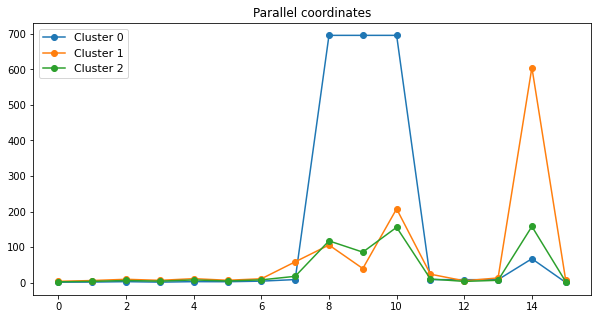

In [6]:
visualize_parallel_coordinates(X, centers, 'kmeans-parcoord-1.png')

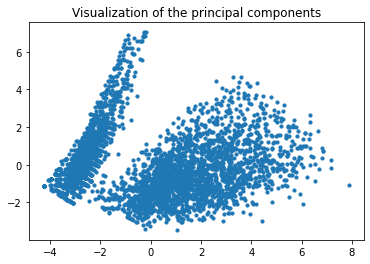

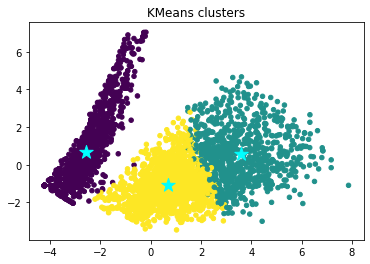

In [7]:
visualize_in_2d(X, kmeans, 'kmeans-clusters-1.png')

## 2. KMeans Analysis removing features manually based on parallel coordinates

According to parallel coordinates plot, we take into account only the features:
- 'Distinct Products'
- 'Mean Days btw Purchases'
- 'Min Days btw Purchases'
- 'Max Days btw Purchases'
- 'Total Products'

In [8]:
dataset = load_dataset()
dataset = dataset[['Distinct Products','Mean Days btw Purchases','Min Days btw Purchases','Max Days btw Purchases','Total Products']]
dataset, scaler = standardize(dataset)
X = deepcopy(dataset)

***K=3*** is the best value according to the SSE score <br/>
***K=3*** is the best value according to the silhouette score

Retraining the model with the right hyperparameters

In [9]:
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=200)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [10]:
print(f"SSE: {kmeans.inertia_}, Silhouette: {silhouette_score(X, kmeans.labels_)}")

SSE: 2833.905144686139, Silhouette: 0.6666120113437053


In [11]:
X['kmean'] = kmeans.labels_
print(X['kmean'].value_counts())
del X['kmean']

2    1636
1    1518
0     570
Name: kmean, dtype: int64


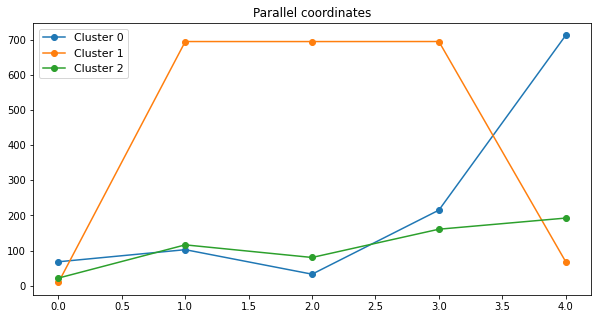

In [12]:
visualize_parallel_coordinates(X, centers, 'kmeans-parcoord-2.png')

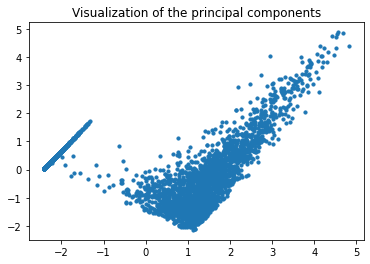

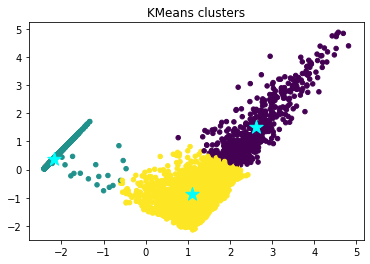

In [13]:
visualize_in_2d(X, kmeans, 'kmeans-clusters-2.png')

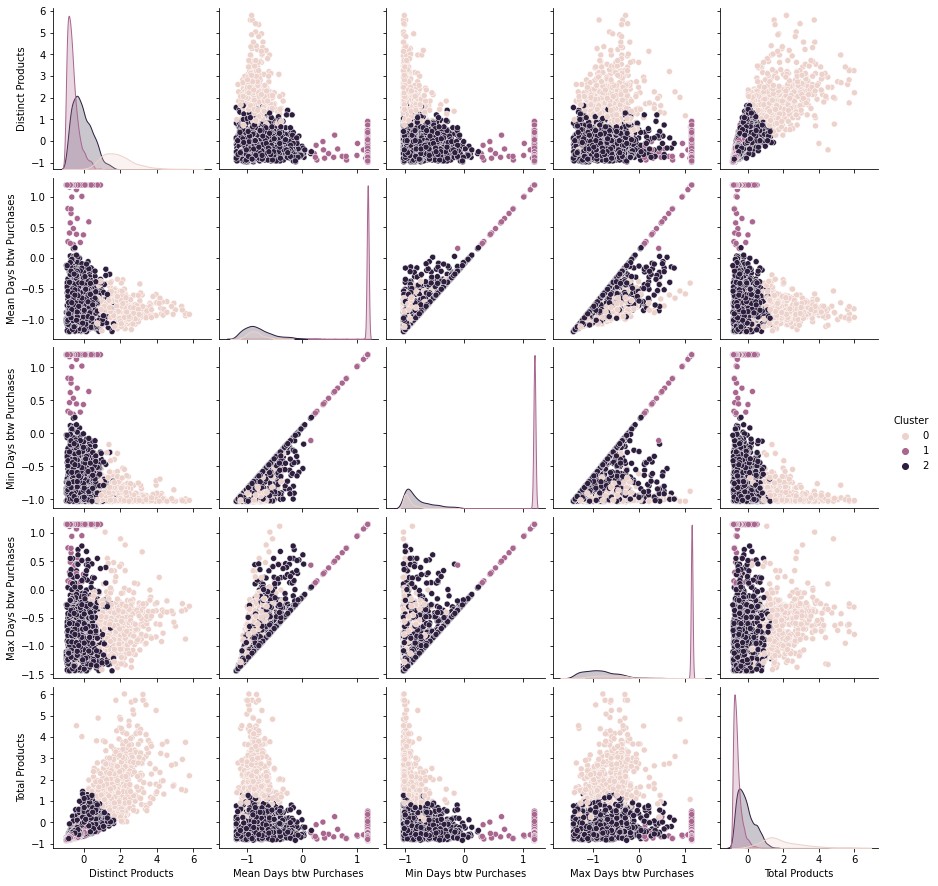

In [14]:
# creation of the dataset with the labels
customers = pd.DataFrame(X.index)
labels = pd.DataFrame(kmeans.labels_, columns=['Cluster'])
customers = customers.join(labels)
customers = customers.set_index('CustomerID')
labeled_df = customers.join(X, on='CustomerID')
pp = sns.pairplot(labeled_df, hue="Cluster", diag_kind='kde')

In [15]:
pp.savefig(os.path.join('plots', 'kmeans-pairplot-2.png'))

## 3. KMeans Analysis removing features manually

In [16]:
dataset = load_dataset()
dataset = dataset[['Mean Days btw Purchases', 'Money Spent Entropy', 'Mean Products In Basket']]
dataset, scaler = standardize(dataset)
X = deepcopy(dataset)

***K=4*** is the best value according to the SSE score <br/>
***K=4*** is the best value according to the silhouette score

In [17]:
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=200)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [18]:
print(f"SSE: {kmeans.inertia_}, Silhouette: {silhouette_score(X, kmeans.labels_)}")

SSE: 3885.7131116170162, Silhouette: 0.4618070808972326


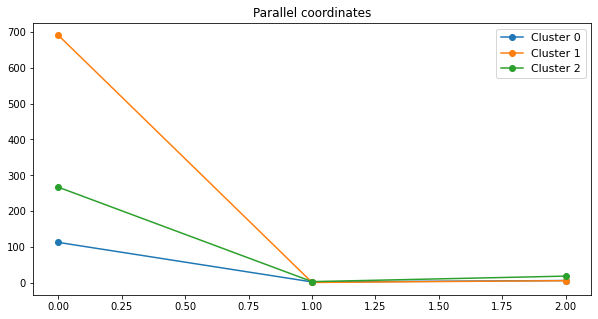

In [19]:
visualize_parallel_coordinates(X, centers, 'kmeans-parcoord-3.png')

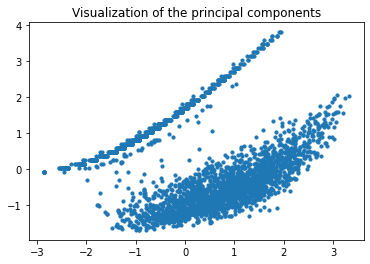

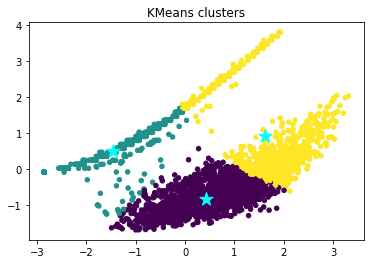

In [20]:
visualize_in_2d(X, kmeans, 'kmeans-clusters-3.png')

## 4. Kmeans Analysis with uncorrelated features

In [21]:
dataset = load_dataset()
dataset, scaler = standardize(dataset)

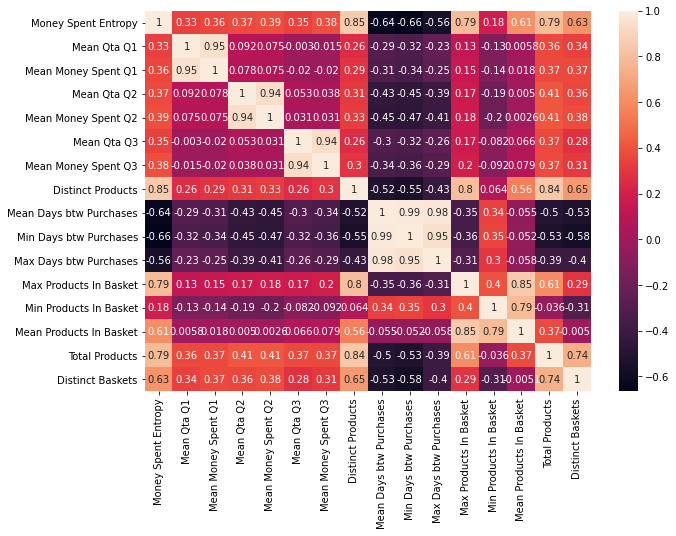

In [22]:
corr_df = dataset.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(corr_df, annot=True, ax=ax)
plt.savefig(os.path.join('plots', 'kmeans-corr-4.png'))

***'Mean Days btw Purchases', 'Min Days btw Purchases' and 'Max Days btw Purchases'*** are highly correlated.

In [23]:
d = {
    'Mean Days btw Purchases': corr_df['Mean Days btw Purchases'].sum(),
    'Min Days btw Purchases': corr_df['Min Days btw Purchases'].sum(),
    'Max Days btw Purchases': corr_df['Max Days btw Purchases'].sum()
}
print(f"We choose '{min(d.items(), key=operator.itemgetter(1))[0]}' because has lower cumulative correlation w.r.t. the other features.")

We choose 'Min Days btw Purchases' because has lower cumulative correlation w.r.t. the other features.


***'Max Products In Basket', 'Min Products In Basket' and 'Mean Products In Basket'*** are highly correlated.

In [24]:
d = {
    'Max Products In Basket': corr_df['Max Products In Basket'].sum(),
    'Min Products In Basket': corr_df['Min Products In Basket'].sum(),
    'Mean Products In Basket': corr_df['Mean Products In Basket'].sum()
}
print(f"We choose '{min(d.items(), key=operator.itemgetter(1))[0]}' because has lower cumulative correlation w.r.t. the other features.")

We choose 'Min Products In Basket' because has lower cumulative correlation w.r.t. the other features.


***'Mean Qta Q1' and 'Mean Money Spent Q1'*** are highly correlated.

In [25]:
d = {
    'Mean Qta Q1': corr_df['Mean Qta Q1'].sum(),
    'Mean Money Spent Q1': corr_df['Mean Money Spent Q1'].sum()
}
print(f"We choose '{min(d.items(), key=operator.itemgetter(1))[0]}' because has lower cumulative correlation w.r.t. the other features.")

We choose 'Mean Qta Q1' because has lower cumulative correlation w.r.t. the other features.


***'Mean Qta Q2' and 'Mean Money Spent Q2'*** are highly correlated.

In [26]:
d = {
    'Mean Qta Q2': corr_df['Mean Qta Q2'].sum(),
    'Mean Money Spent Q2': corr_df['Mean Money Spent Q2'].sum()
}
print(f"We choose '{min(d.items(), key=operator.itemgetter(1))[0]}' because has lower cumulative correlation w.r.t. the other features.")

We choose 'Mean Money Spent Q2' because has lower cumulative correlation w.r.t. the other features.


***'Mean Qta Q3' and 'Mean Money Spent Q3'*** are highly correlated.

In [27]:
d = {
    'Mean Qta Q3': corr_df['Mean Qta Q3'].sum(),
    'Mean Money Spent Q3': corr_df['Mean Money Spent Q3'].sum()
}
print(f"We choose '{min(d.items(), key=operator.itemgetter(1))[0]}' because has lower cumulative correlation w.r.t. the other features.")

We choose 'Mean Qta Q3' because has lower cumulative correlation w.r.t. the other features.


In [28]:
selected_features = ['Money Spent Entropy','Mean Qta Q1','Mean Money Spent Q2','Mean Qta Q3','Min Days btw Purchases','Min Products In Basket','Distinct Products','Total Products','Distinct Baskets']

In [29]:
dataset = dataset[selected_features]
dataset, scaler = standardize(dataset)
X = deepcopy(dataset)

***K=3*** is the best value according to the SSE score <br/>
***K=17*** is the best value according to the silhouette score

In [30]:
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=200)
kmeans.fit(X)
centers = scaler.inverse_transform(kmeans.cluster_centers_)

In [31]:
print(f"SSE: {kmeans.inertia_}, Silhouette: {silhouette_score(X, kmeans.labels_)}")

SSE: 18259.272603682006, Silhouette: 0.24926834571005269


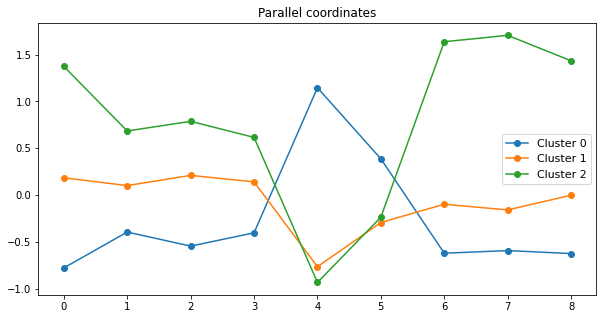

In [32]:
visualize_parallel_coordinates(X, centers, 'kmeans-parcoord-4.png')

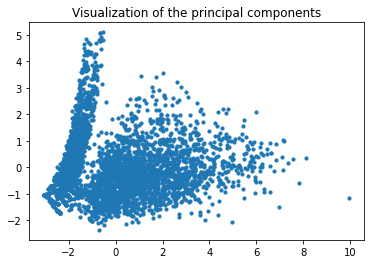

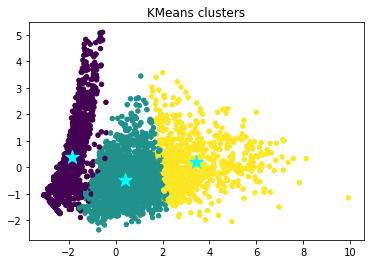

In [33]:
visualize_in_2d(X, kmeans, 'kmeans-clusters-4.png')

In [34]:
X['kmean'] = kmeans.labels_
X['kmean'].value_counts()

0    1551
1    1491
2     682
Name: kmean, dtype: int64

1) SSE: 33636.40764288619, Silhouette: 0.25701231665323737 <br/>
2) SSE: 2833.905144686139, Silhouette: 0.6666120113437053 <br/>
3) SSE: 3885.7131116170162, Silhouette: 0.4618070808972326 <br/>
4) SSE: 18259.272603682006, Silhouette: 0.24926834571005269